## First look into SM muon decays

* $\mu^+ \to e^+ \nu_e \overline{\nu}_\mu$
* $\mu^+ \to e^+ \nu_e \overline{\nu}_\mu e^+e^-$
* $\mu^+ \to e^+ \nu_e \overline{\nu}_\mu e^+e^-e^+e^-$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from phasespace import GenParticle

from particle import literals as lp # --> MeV units
import hepunits as u # converting to GeV

2023-05-05 17:33:57.392779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Grabbing amplitude from MadGraph matrix2py modules

For example, from within MG, we generate the process without higsses and Z bosons by typying:

---
```
import model sm-lepton_masses
generate mu+ > vm~ ve e+ e+ e- e+ e- / z h
output standalone ../m5e2nu
```
---

There are still >200 diagrams, but much better than 2000, as before. Note also I need to use the `sm-lepton_masses`, otherwise I get non-sensical results (probably muons are massless in the default one).

To generate the python wrapper for the fortan amplitude code, we run `make` from the folder `m5e2nu/SubProcesses`. (I could also chosen to run `make matrix2py.so` from within the folder `P1_mup_vmxveepepemepem_no_zh`, but this seems to work as well).

---
### Evaluating the amplitude square $|\mathcal{M}|^2$ 

Recall that the units of $<|\mathcal{M}|^2> = {\rm GeV}^n$, where

* $ n = -(2 n_{\rm ext}-8)$

and $n_{\rm ext}$ is the number of external particles. For $\mu \to e \nu \nu$, $n = 0$, $\mu \to e ee \nu \nu$, $n = -4$, and $\mu \to e ee ee \nu \nu$, $n = -8$.

**NOTE**:: MadGraph returns the square of the amplitude after symmetry factors and summed over helicities.

**TODO**: I still don't know if it has any phase space density factors... Need to check

In [3]:
from Mu3e.mu1e2nu.SubProcesses.P1_mup_vmxveep_no_zh import matrix2py as amp_mu1e2nu
amp_mu1e2nu.initialisemodel('mu1e2nu/Cards/param_card.dat')

In [10]:
# import the amplitude model from each process:
from Mu3e.mu1e2nu.SubProcesses.P1_mup_vmxveep_no_zh import matrix2py as amp_mu1e2nu
from Mu3e.mu3e2nu.SubProcesses.P1_mup_vmxveepepem_no_zh import matrix2py as amp_mu3e2nu
from Mu3e.mu5e2nu.SubProcesses.P1_mup_vmxveepepemepem_no_zh import matrix2py as amp_mu5e2nu

In [11]:
# initialize the models for each one
amp_mu1e2nu.initialisemodel('Mu3e/mu1e2nu/Cards/param_card.dat')
amp_mu3e2nu.initialisemodel('Mu3e/mu3e2nu/Cards/param_card.dat')
amp_mu5e2nu.initialisemodel('Mu3e/mu5e2nu/Cards/param_card.dat')

### Some total lifetimes calculated by MadGraph:

In [12]:
def I(x):
    return 1 - 8*x - 12* x**2 * np.log(x) + 8*x**3 - x**4
r = (lp.e_minus.mass/lp.mu_minus.mass)**2
Gamma_mu = (1.16e-5)**2 * (lp.mu_minus.mass/u.GeV)**5 / (192 * np.pi**3) * I(r)

print(f'Gamma_tot = {Gamma_mu:.2g} GeV, where I(x) = {I(r):.5g}')

# Results from MadGraph run: 

# 3e2nu seem ok! -- BR ~ 3.6e-5 # from https://arxiv.org/pdf/1811.10965.pdf
BR_mu3e2nu = 1.155e-23/Gamma_mu
# 5e2nu -- no known resul in literature, but (alpha/4pi)^4 ~ 1e-13...?
BR_mu5e2nu = 1.342e-28/Gamma_mu

print(rf'$\mathcal{{B}}(\mu^+ \to \overline\nu_\mu \nu_e e^+e^+e^-) = ({1.155e-23/Gamma_mu*1e5:.2g} \pm {4.289e-26/Gamma_mu*1e5:.2g}) \times 10^{{-5}}$')
print(rf'$\mathcal{{B}}(\mu^+ \to \overline\nu_\mu \nu_e e^+e^+e^-e^+e^-) = ({1.342e-28/Gamma_mu*1e10:.2g} \pm {4.1e-31/Gamma_mu*1e10:.2g}) \times 10^{{-10}}$')

Gamma_tot = 3e-19 GeV, where I(x) = 0.99981
$\mathcal{B}(\mu^+ \to \overline\nu_\mu \nu_e e^+e^+e^-) = (3.9 \pm 0.014) \times 10^{-5}$
$\mathcal{B}(\mu^+ \to \overline\nu_\mu \nu_e e^+e^+e^-e^+e^-) = (4.5 \pm 0.014) \times 10^{-10}$


### Defining a class for the events and amplitude

In [13]:
class Process:
    """Class to store the events generated by `phasespace`"""
    
    def __init__(self, particles, weights, wmax=None, amp=None, branching=1.0):
        """initialize the class and put format the momenta correctly"""

        # output arrays from phasespace's generate(...)
        self.particles = particles
        self.weights = np.array(weights)
        self.wmax = np.array(wmax)

        self.branching = branching

        # amplitude module (already model initialised) from MG@5
        self.amp = amp
        self.alphaS = 0.12 # alpha strong -- not relevant for us.
        self.nhel = 0 # summ over all helicites -- TODO not sure how to use it in any other way...

        self.n_events = len(self.weights)

        # list of daughter particles
        self.daughter_names = list(self.particles.keys())

        # 4-momentum of the parent particle
        # self.p_parent = np.zeros_like(self.particles[self.daughter_names[0]])
        self.p_parent = np.sum([self.particles[k] for k in self.daughter_names], axis=0)
        
        self.put_energy_first()
        
        self.P_grid = self.build_P_grid()        
    
   
    def put_energy_first(self):
        # We need to rearrange the arrays so the first enetry is energy, and not px:
        # `phasespace` indices: 0 -> px, 1 -> py, 2 -> pz, 3 -> E
        # `MadGraph` and `DarkNews` indices: 0 -> E, 1 -> px, 2 -> py, 3 -> pz
        # when rearranging, also convert from TensorFlow object to numpy array
        for k in self.daughter_names:
            self.particles[k] = np.array(self.particles[k])[:,[3,0,1,2]]
        self.p_parent = self.p_parent[:,[3,0,1,2]]

    def build_P_grid(self):
        # dim 0: event number
        # dim 1: lorentz index
        # dim 2: particle number
        
        # Ordering --> Parent + daughters(following MadGraph convention)
        return np.transpose([self.p_parent] + [self.particles[k] for k in self.daughter_names], axes=(1,2,0) )
    
    def amp_in_P(self,P):
        if self.amp:
            return self.amp.get_value(P, self.alphaS, self.nhel)
    
    def amp_in_Pgrid(self):
        if self.amp:
            # loops over events and evaluates the amplitude given the list of momenta 
            self.w_amp = np.array([self.amp.get_value(self.P_grid[i], self.alphaS, self.nhel) for i in range(self.n_events)])
            self.w_final = self.w_amp * self.weights * self.branching / np.sum(self.w_amp * self.weights)

### Evaluate the amplitude square $|\mathcal{M}|^2$ for the first event

Recall that the units of $|\mathcal{M}|^2$ are

$$ n = {\rm GeV}^{-(2 n_{\rm ext}-8)}$$

where $n_{\rm ext}$ is the number of external particles. For $\mu \to e \nu \nu$, $n = 0$ and $\mu \to e ee \nu \nu$, $n = -4$.

NOTE: MadGraph returns the square of the amplitude after symmetry factors and summed over helicities.

In [14]:
# ------------------------------------------------------
# # Defining particles involved 
MPARENT = lp.mu_minus.mass/u.GeV

numubar = GenParticle('nu_mu_bar', 0.0)
nue = GenParticle('nu_e', 0.0)

positron_0 = GenParticle('e+_0', lp.e_plus.mass/u.GeV)

electron_1 = GenParticle('e-_1', lp.e_minus.mass/u.GeV)
positron_1 = GenParticle('e+_1', lp.e_plus.mass/u.GeV)

electron_2 = GenParticle('e-_2', lp.e_minus.mass/u.GeV)
positron_2 = GenParticle('e+_2', lp.e_plus.mass/u.GeV)

# ------------------------------------------------------
# µ -> ν_mu_bar ν_e e+
# !! Watch out for the ordering of the particles (following diagrams in MadGraph)
parent_muon_3body = GenParticle('mu+', MPARENT).set_children(
                                            numubar,
                                            nue,
                                            positron_0
                                            )

# ------------------------------------------------------
# µ -> ν_mu_bar ν_e e+ e+ e-
# !! Watch out for the ordering of the particles (following diagrams in MadGraph)
parent_muon_5body = GenParticle('mu+', MPARENT).set_children(
                                            numubar,
                                            nue, 
                                            positron_0, 
                                            positron_1, 
                                            electron_1, 
                                            )

# ------------------------------------------------------
# µ -> ν_mu_bar ν_e e+ e+ e- e+ e-
# !! Watch out for the ordering of the particles (following diagrams in MadGraph)
parent_muon_7body = GenParticle('mu+', MPARENT).set_children(
                                            numubar,
                                            nue, 
                                            positron_0, 
                                            positron_1, 
                                            electron_1, 
                                            positron_2, 
                                            electron_2, 
                                            )

# ------------------------------------------------------
# Generate the 4 momenta and weights

NEVENTS = 1e5

_weights, _wmax,  _particles = parent_muon_3body.generate(n_events=NEVENTS, normalize_weights=False)
m_e2nu = Process(_particles, _weights, wmax=_wmax, amp=amp_mue2nu, branching = 1)

# Generate the 4 momenta and weights
_weights, _wmax,  _particles = parent_muon_5body.generate(n_events=NEVENTS, normalize_weights=False)
m_3e2nu = Process(_particles, _weights, wmax=_wmax, amp=amp_mu3e2nu, branching = BR_mu3e2nu)

# Generate the 4 momenta and weights
_weights, _wmax,  _particles = parent_muon_7body.generate(n_events=NEVENTS, normalize_weights=False)
m_5e2nu = Process(_particles, _weights, wmax=_wmax, amp=amp_mu5e2nu, branching = BR_mu5e2nu)

In [15]:
# Test the matrix element on a single event
print(amp_mue2nu.get_value(m_e2nu.P_grid[0], 0.0, -1))
print(amp_mu3e2nu.get_value(m_3e2nu.P_grid[0], 0.0, -1))
print(amp_mu5e2nu.get_value(m_5e2nu.P_grid[0], 0.0, -1))

2.4099235467576755e-14
2.8185156792155023e-08
1.0782455792730287e-05


### Evaluating the matrix element squared for the list of momenta

In [16]:
m_e2nu.amp_in_Pgrid()

In [17]:
m_3e2nu.amp_in_Pgrid()

In [18]:
# This may be slow depending on the number of events
# On my laptop -- ~1.5s per 1k events

m_5e2nu.amp_in_Pgrid()

### Some simple tests

In [ ]:
# check energy conservation
# all total energies should be equal to the parent muon mass

Etot = np.sum([m_e2nu.particles[p][:,0] for p in m_e2nu.daughter_names], axis=0)
print(np.max(np.abs(Etot - MPARENT)))

Etot = np.sum([m_3e2nu.particles[p][:,0] for p in m_3e2nu.daughter_names], axis=0)
print(np.max(np.abs(Etot - MPARENT)))

Etot = np.sum([m_5e2nu.particles[p][:,0] for p in m_5e2nu.daughter_names], axis=0)
print(np.max(np.abs(Etot - MPARENT)))

2.280656066777631e-09
6.311122457969276e-10
3.065402377766535e-08


In [ ]:
# Importing some functions I used in DarkNews
from DarkNews import Cfourvec as Cfv
from DarkNews import const
from DarkNews import plot_tools as pt

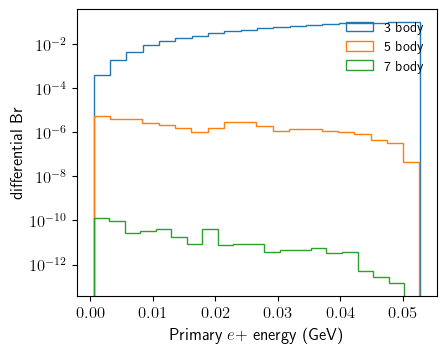

In [ ]:
fig, ax = pt.std_fig()

E_3 = m_e2nu.particles['e+_0']
E_5 = m_3e2nu.particles['e+_0']
E_7 = m_5e2nu.particles['e+_0']

_ = ax.hist(E_3[:,0], bins=20, weights=m_e2nu.w_final, histtype='step', label=r'3 body', density=False)
_ = ax.hist(E_5[:,0], bins=20, weights=m_3e2nu.w_final, histtype='step', label=r'5 body', density=False)
_ = ax.hist(E_7[:,0], bins=20, weights=m_5e2nu.w_final, histtype='step', label=r'7 body', density=False)


ax.set_xlabel(r'Primary $e+$ energy (GeV)')
ax.set_ylabel(r'differential Br')
ax.legend()
ax.set_yscale('log')

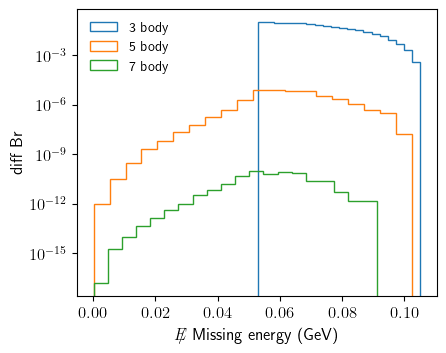

In [ ]:
fig, ax = pt.std_fig()

p_miss_3 = m_e2nu.particles['nu_mu_bar'] + m_e2nu.particles['nu_e'] 
p_miss_5 = m_3e2nu.particles['nu_mu_bar'] + m_3e2nu.particles['nu_e'] 
p_miss_7 = m_5e2nu.particles['nu_mu_bar'] + m_5e2nu.particles['nu_e'] 

_ = ax.hist(p_miss_3[:,0], bins=20, weights=m_e2nu.w_final, histtype='step', label=r'3 body', density=False)
_ = ax.hist(p_miss_5[:,0], bins=20, weights=m_3e2nu.w_final, histtype='step', label=r'5 body', density=False)
_ = ax.hist(p_miss_7[:,0], bins=20, weights=m_5e2nu.w_final, histtype='step', label=r'7 body', density=False)


ax.set_xlabel(r'$E\!\!\!/$ Missing energy (GeV)')
ax.set_ylabel(r'differential Br')
ax.legend()
ax.set_yscale('log')

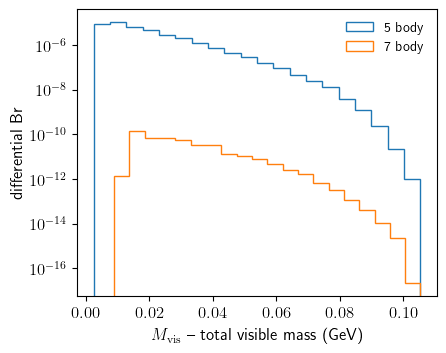

In [ ]:
fig, ax = pt.std_fig()

m_miss_3 = np.sqrt(Cfv.dot4(m_e2nu.particles['nu_mu_bar'] + m_e2nu.particles['nu_e'], m_e2nu.particles['nu_mu_bar'] + m_e2nu.particles['nu_e']))
m_miss_5 = np.sqrt(Cfv.dot4(m_3e2nu.p_parent - m_3e2nu.particles['nu_mu_bar'] - m_3e2nu.particles['nu_e'], m_3e2nu.p_parent - m_3e2nu.particles['nu_mu_bar'] - m_3e2nu.particles['nu_e']))
m_miss_7 = np.sqrt(Cfv.dot4(m_5e2nu.p_parent - m_5e2nu.particles['nu_mu_bar'] - m_5e2nu.particles['nu_e'], m_5e2nu.p_parent - m_5e2nu.particles['nu_mu_bar'] - m_5e2nu.particles['nu_e']))

# _ = ax.hist(m_miss_3, bins=20, weights=m_e2nu.w_final, histtype='step', label=r'3 body', density=False)
_ = ax.hist(m_miss_5, bins=20, weights=m_3e2nu.w_final, histtype='step', label=r'5 body', density=False)
_ = ax.hist(m_miss_7, bins=20, weights=m_5e2nu.w_final, histtype='step', label=r'7 body', density=False)

ax.set_xlabel(r'$M_{\rm vis}$ -- total visible mass (GeV)')
ax.set_ylabel(r'differential Br')
ax.legend()
ax.set_yscale('log')

---
### Some lower-level tests

The weights seem ok -- there are no jumps in the 7 body decay case. I think this means we are sampling the PS broadly enough. 

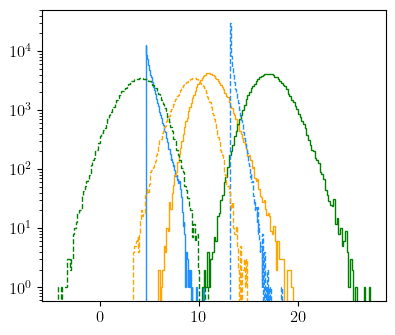

In [ ]:
# check the distribution of weights is reasonable
_ = plt.hist(-np.log10(m_e2nu.w_final), bins=100, histtype='step', color='dodgerblue')
_ = plt.hist(-np.log10(m_3e2nu.w_final), bins=100, histtype='step', color='orange')
_ = plt.hist(-np.log10(m_5e2nu.w_final), bins=100, histtype='step', color='green')

# check the distribution of weights is reasonable
_ = plt.hist(-np.log10(m_e2nu.w_amp), bins=100, histtype='step', ls='--', color='dodgerblue')
_ = plt.hist(-np.log10(m_3e2nu.w_amp), bins=100, histtype='step', ls='--', color='orange')
_ = plt.hist(-np.log10(m_5e2nu.w_amp), bins=100, histtype='step', ls='--', color='green')


plt.yscale('log')

In [ ]:
from math import factorial
def phase_space_vol(M,n):
    return 1/2 * 1/(4*np.pi)**(2*n - 3) * M**(2*n - 4)  / factorial(n - 2) / factorial(n - 1)
PS3vol = const.m_mu**2/256/np.pi**3
phase_space_vol(const.m_mu, 3)/PS3vol

1.0

In [8]:
PS5vol = phase_space_vol(const.m_mu, 5)
my_pred_mu3e2nu = np.sum(mu3e2nu_final_w)*PS5vol/2/const.m_mu/np.sum(m_3e2nu.weights)
my_pred_mu3e2nu/Gamma_mu3e2nu

NameError: name 'phase_space_vol' is not defined